# Copulas as High-Dimensional Generative Models: Vine Copula Autoencoders

***Natasa Tagasovska, Damien Ackerer and Thibault Vatter. NeurIPS, 2019.***

* **Aim:** autoencoder+vine+copula, 希望在MedMNIST数据集中应用这种方法。

https://github.com/tagas/vcae

The dataset had been utilized in this paper: MNIST,  Street View House Numbers, and one large scale - CelebA.

We may try

* **MedMNIST-organmnist_axial**

https://medmnist.github.io/

Ting,
2020.12.29








In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

from torch import nn

import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr

base = importr('base')
rvinecop = importr('rvinecopulib')

In [2]:
_MNIST_TRAIN_TRANSFORMS = _MNIST_TEST_TRANSFORMS = [
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.Pad(2),
    transforms.ToTensor(),
]





DATASET_CONFIGS = {
    'mnist': {'size': 32, 'channels': 1, 'classes': 10},
    
    
    
    'Medmnist':{'size': 32, 'channels': 1, 'classes': 10}
}


label= {
            "0": "bladder",
            "1": "femur-left",
            "2": "femur-right",
            "3": "heart",
            "4": "kidney-left",
            "5": "kidney-right",
            "6": "liver",
            "7": "lung-left",
            "8": "lung-right",
            "9": "pancreas",
            "10": "spleen"
        }
    
n_channels =1
n_samples={
            "train": 34581,
            "val": 6491,
            "test": 17778
        }
n_classes=10

In [3]:
class MedMNIST(Dataset):

   

    def __init__(self,
                 root,
                 split='train',
                 transform=None,
                 target_transform=None):
        ''' dataset
        :param split: 'train', 'val' or 'test', select subset
        :param transform: data transformation
        :param target_transform: target transformation
    
        '''

        
        self.root=root

        

        

        npz_file = np.load('medmnist/organmnist_axial.npz')

        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        if self.split == 'train':
            self.img = npz_file['train_images']
            self.label = npz_file['train_labels']
        elif self.split == 'val':
            self.img = npz_file['val_images']
            self.label = npz_file['val_labels']
        elif self.split == 'test':
            self.img = npz_file['test_images']
            self.label = npz_file['test_labels']

    def __getitem__(self, index):
        img, target = self.img[index], self.label[index].astype(np.uint8)
        img = Image.fromarray(np.uint8(img))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target,index

    def __len__(self):
        return self.img.shape[0]



In [4]:



    
TRAIN_DATASETS = {
   
    'Medmnist': MedMNIST(
        'medmnist', split='train', 
        transform=transforms.Compose(_MNIST_TRAIN_TRANSFORMS)
    ),
   
}


TEST_DATASETS = {
    
    
    'Medmnist': MedMNIST(
        'medmnist', split='test', 
        transform=transforms.Compose(_MNIST_TRAIN_TRANSFORMS)
    ),
}


In [5]:
dataset_config=DATASET_CONFIGS['Medmnist']
dataset = TRAIN_DATASETS['Medmnist']
image_size =32
evaluation_sample_size=2000
gan_type = 0
init_channel = 32

In [6]:
def _conv(channel_size, kernel_num):
    return nn.Sequential(
        nn.Conv2d(
            channel_size, kernel_num,
            kernel_size=4, stride=2, padding=1,
        ),
        nn.BatchNorm2d(kernel_num),
        nn.ReLU(),
    )

def _deconv(channel_num, kernel_num):
    return nn.Sequential(
        nn.ConvTranspose2d(
            channel_num, kernel_num,
            kernel_size=4, stride=2, padding=1,
        ),
        nn.BatchNorm2d(kernel_num),
        nn.ReLU(),
    )

def _linear(in_size, out_size, relu=True):
    return nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.ReLU(),
    ) if relu else nn.Linear(in_size, out_size)

In [7]:
class ae_vine(nn.Module):
    def __init__(self, label, image_size, channel_num, kernel_num, z_size, device):
        super().__init__()
        self.model_name = "ae_vine"
        self.label = label
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size
        self.device = device
        self.vine = None

        # encoder
        self.encoder = nn.Sequential(
            _conv(channel_num, kernel_num // 4),
            _conv(kernel_num // 4, kernel_num // 2),
            _conv(kernel_num // 2, kernel_num),
        )

        # encoded feature's size and volume
        self.feature_size = image_size // 8
        self.feature_volume = kernel_num * (self.feature_size ** 2)

        # decoder
        self.decoder = nn.Sequential(
            _deconv(kernel_num, kernel_num // 2),
            _deconv(kernel_num // 2, kernel_num // 4),
            _deconv(kernel_num // 4, channel_num),
            nn.Sigmoid()
        )

        # projection
        self.project = _linear(z_size, self.feature_volume, relu=False)
        self.q_layer = _linear(self.feature_volume, z_size, relu=False)

    def q(self, encoded):
        unrolled = encoded.view(-1, self.feature_volume)
        return self.q_layer(unrolled)

    def forward(self, x):
        encoded = self.encoder(x)
        # flatten and reshape for decoder
        z = self.q(encoded)

        x_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )

        x_reconstructed = self.decoder(x_projected)

        return x_reconstructed

    def sample(self, size, vine, noise=None):

            if noise is None:
                sampled_r = rvinecop.rvine(size, vine)
            else:
                sampled_r = rvinecop.inverse_rosenblatt(noise.cpu().numpy(), vine)

            sampled_py = torch.Tensor(np.asarray(sampled_r)).view(size, -1).to(self.device)

            # transform vine samples in shape for decoder
            sample_projected = self.project(sampled_py).view(
                -1, self.kernel_num,
                self.feature_size,
                self.feature_size,
            )
            del sampled_py, sampled_r
            output_vine = self.decoder(sample_projected)
            del sample_projected
            return output_vine

In [8]:
np.random.seed(42)
device=torch.device("cpu")
model = ae_vine(
            label=dataset,
            image_size=dataset_config['size'],
            channel_num=dataset_config['channels'],
            kernel_num=128,
            z_size=10,
            device=device
        )



In [9]:

import random
from torch.utils.data import DataLoader

def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_data_loader(dataset, batch_size, cuda=False):
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        **({'num_workers': 1, 'pin_memory': True} if cuda else {})
    )


def save_checkpoint(model, model_dir, epoch, resfile_prefix):
    path = os.path.join(model_dir, resfile_prefix)

    # save the checkpoint.
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save({'state': model.state_dict(), 'epoch': epoch}, path)

    # notify that we successfully saved the checkpoint.
    print('=> saved the model {name} to {path}'.format(
        name=resfile_prefix, path=path
    ))


def load_checkpoint(model, model_dir,resfile_prefix):
    path = os.path.join(model_dir, resfile_prefix)

    # load the checkpoint.
    checkpoint = torch.load(path)
    print('=> loaded checkpoint of {name} from {path}'.format(
        name=resfile_prefix, path=(path)
    ))

    # load parameters and return the checkpoint's epoch and precision.
    model.load_state_dict(checkpoint['state'])
    epoch = checkpoint['epoch']
    return epoch


def xavier_initialize(model):
    modules = [
        m for n, m in model.named_modules() if
        'conv' in n or 'linear' in n
    ]

    parameters = [
        p for
        m in modules for
        p in m.parameters() if
        p.dim() >= 2
    ]

    for p in parameters:
        init.xavier_normal(p)

In [10]:
from torch import optim
from tqdm import tqdm


In [12]:
dataset=dataset
ds_name='medmnist'
epochs=4
batch_size=400
sample_size=64
eval_size=2000
img_size=32
lr=1e-03
weight_decay=1e-03
checkpoint_dir='checkpoints'
results_dir='results'
loss_log_interval=100
image_log_interval=20
model_log_interval=100
resume=False
cuda=False
seed=42
device=device
cores=4

lossseq=[]

In [13]:
import torchvision.utils as vutils


            
    

resfile_prefix = ds_name + "_" + \
                model.model_name + \
                "_ld_" + \
                str(model.z_size) + \
                "_bs_" + str(batch_size)
    
if resume:
    epoch_start = load_checkpoint(model, checkpoint_dir,resfile_prefix)
else:
    epoch_start = 0

fixed_noise = torch.rand(sample_size, model.z_size).to(device)

if model.model_name in ['vae', 'vae2', 'vae3']:
    m = dist.Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.0]).to(device))
    fixed_noise = m.icdf(fixed_noise)

output_folder = results_dir + ds_name
    

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

data_root = './datasets'

# DEC-VINE preclustering setup and training
if model.model_name in ['dec_vine', 'dec_vine2', 'dec_vine3']:

# load pre-trained AE
    if model.model_name == 'dec_vine':
        pretrain_prefix = resfile_prefix.replace("dec", "ae")
    elif model.model_name == 'dec_vine2':
        pretrain_prefix = resfile_prefix.replace("dec_vine2", "ae_vine2")
    elif model.model_name == 'dec_vine3':
        pretrain_prefix = resfile_prefix.replace("dec_vine3", "ae_vine3")
        
    pretrain_files = [filename for filename in os.listdir(checkpoint_dir) if filename.startswith(pretrain_prefix)]
    pretrain_epochs = [int(filename.replace(pretrain_prefix + "_", "")) for filename in pretrain_files]
    pretrain_path = os.path.join(checkpoint_dir, pretrain_files[pretrain_epochs.index(max(pretrain_epochs))])

    model.pretrain(pretrain_path)

    # form initial cluster centres
    data_loader = get_data_loader(dataset, batch_size, cuda=cuda)
    data_stream = tqdm(enumerate(data_loader, 1))
    features = []

    for batch_index, (x, _, _) in data_stream:
        tmp_x = Variable(x).to(device)
        if model.model_name == 'dec_vine':
            z = model.ae.encoder(tmp_x)
            z = model.ae.q(z)
        elif model.model_name == 'dec_vine2' or  model.model_name == 'dec_vine3':
            z = torch.nn.functional.relu(model.ae.fc1(model.ae.encoder(tmp_x).view(x.size(0), -1)))
            z = model.ae.fc21(z)

        features.append(z)

    kmeans = KMeans(n_clusters=model.cluster_number, n_init=20)
    y_pred = kmeans.fit_predict(torch.cat(features).detach().cpu().numpy())
    model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)

    # load a pre-trained state for any model
pretrain=0
    
if  pretrain==1 and model.model_name == 'ae_vine3':
        
    pretrain_prefix = resfile_prefix
    pretrain_files = [filename for filename in os.listdir(checkpoint_dir) if filename.startswith(pretrain_prefix)]
    pretrain_epochs = [int(filename.replace(pretrain_prefix + "_", "")) for filename in pretrain_files]
    pretrain_path = os.path.join(checkpoint_dir, pretrain_files[pretrain_epochs.index(max(pretrain_epochs))])
    pretrained_ae = torch.load(pretrain_path, map_location=device)
        
    model.load_state_dict(pretrained_ae['state'])
    print('load pretrained ae3 from', pretrain_path)


    # reconstruction_criterion = torch.nn.BCELoss()
reconstruction_criterion = torch.nn.BCELoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if model.model_name == 'gan':
    lr_g = lr_d = 0.0002
    k = 1
    fix_noise = get_noise(sample_size)
    opt_g = torch.optim.Adam(model.net_g.parameters(), lr=lr_g, betas=(0.5, 0.999))  # optimizer for Generator
    opt_d = torch.optim.Adam(model.net_d.parameters(), lr=lr_d, betas=(0.5, 0.999))  # optimizer for Discriminator

for epoch in range(epoch_start, epochs + 1):
    print("Epoch {}".format(epoch))
        
    if model.model_name == "dec_vine" or model.model_name == "dec_vine2":
        model.eval()
        p = []
        indices = []
        data_loader = get_data_loader(dataset, batch_size, cuda=cuda)
        data_stream = tqdm(enumerate(data_loader, 1))

        for batch_index, (x, _, idx) in data_stream:
            tmp_x = Variable(x).to(device)
            _, tmp_p = model(tmp_x)
            p.append(tmp_p.detach().cpu())
            tmp_idx = idx
            indices.append(tmp_idx)

        p = torch.cat(p)
        indices = torch.cat(indices)
        p = model.target_distribution(p[indices])
        p = Variable(p).to(device)

    model.train()
    data_loader = get_data_loader(dataset, batch_size, cuda=cuda)
    data_stream = tqdm(enumerate(data_loader, 1))

    for batch_index, (x, _, idx) in data_stream:
            
            # learning rate decay
        if  model.model_name == 'gan' and (epoch) == 8:
            opt_g.param_groups[0]['lr'] /= 10
            opt_d.param_groups[0]['lr'] /= 10

        if model.model_name == 'gan' and (epoch) == 15:
            opt_g.param_groups[0]['lr'] /= 10
            opt_d.param_groups[0]['lr'] /= 10
            
        iteration = (epoch - 1) * (len(dataset) // batch_size) + batch_index
        x = Variable(x).to(device)
        idx = Variable(idx).to(device)


        if model.model_name == 'gan':
                # train Discriminator
            real_data = Variable(x.cuda())
            prob_fake = model.net_d(model.net_g(get_noise(real_data.size(0)).to(device)))
            prob_real = model.net_d(real_data)

            loss_d = - torch.mean(torch.log(prob_real) + torch.log(1 - prob_fake))

            opt_d.zero_grad()
            loss_d.backward()
            opt_d.step()

                # train Generator
            if batch_index % k is 0:
                prob_fake = model.net_d(model.net_g(get_noise().to(device)))

                loss_g = - torch.mean(torch.log(prob_fake))

                opt_g.zero_grad()
                loss_g.backward()
                opt_g.step()

        else:

            if model.model_name == 'ae_vine' or model.model_name == 'ae_vine2' or model.model_name == 'ae_vine3':
                x_reconstructed = model(x)

            elif model.model_name == 'dec_vine' or model.model_name == 'dec_vine2':
                x_reconstructed, q = model(x)
                p_batch = p[idx]
                penalization_loss = 10*F.kl_div(q.log(), p_batch)
                del p_batch, q

            elif model.model_name == 'vae' or model.model_name == "vae2" or model.model_name=="vae3":
                (mean, logvar), x_reconstructed = model(x)
                penalization_loss = model.kl_divergence_loss(mean, logvar)

            if model.model_name == 'vae2' or model.model_name == 'vae3':

                reconstruction_loss = reconstruction_criterion(x_reconstructed, x)# / x.size(0)
            else:
                reconstruction_loss = reconstruction_criterion(x_reconstructed, x) / x.size(0)

            if model.model_name == 'ae_vine' or model.model_name == 'ae_vine2' or model.model_name == 'ae_vine3':
                loss = reconstruction_loss
            else:
                loss = reconstruction_loss + penalization_loss

            lossseq.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if iteration % loss_log_interval == 0:

            f = open(output_folder + "/" + resfile_prefix + "_losses" + ".txt", 'a')

            if model.model_name == 'gan':
                f.write("\n{:<12} | {} | {} | {} | {} ".format(
                        model.model_name,
                        iteration,
                        loss_g,
                        loss_d,
                        seed
                    ))

            else:
                if model.model_name == 'ae_vine' or model.model_name == 'ae_vine2' or model.model_name == 'ae_vine3':
                    f.write("\n{:<12} | {} | {} | {} ".format(
                            model.model_name,
                            iteration,
                            loss,
                            seed
                        ))

                else:
                    f.write("\n{:<12} | {} | {} | {} | {} | {}".format(
                            model.model_name,
                            iteration,
                            reconstruction_loss.data.item(),
                            penalization_loss.data.item(),
                            loss.data.item(),
                            seed
                        ))

            f.close()

            # adding this just to have a way of calculating the scores at 0 epochs
        if batch_index > 0 and epoch == 0:
            break

    if epoch % model_log_interval == 0:
        print()
        print('###################')
        print('# model checkpoint!')
        print('###################')
        print()
        save_checkpoint(model, checkpoint_dir, epoch, resfile_prefix + "_" + str(epoch))

    if epoch <= 10:

        print()
        print('###################')
        print('# image checkpoint!')
        print('###################')
        print()

        model.eval()

        ae_vine_models = ['ae_vine', 'ae_vine2', 'dec_vine', 'dec_vine2', 'ae_vine3', 'dec_vine3']

        if model.model_name in ae_vine_models:

            data_loader_vine = get_data_loader(dataset, 5000, cuda=cuda)
            data_stream_vine = tqdm(enumerate(data_loader_vine, 1))
            features = []

            for batch_index, (x, _, _) in data_stream_vine:

                tmp_x = Variable(x).to(device)
                if model.model_name == 'ae_vine':
                    encoded = model.encoder(tmp_x)
                    e = model.q(encoded)

                elif model.model_name == 'dec_vine':
                    encoded = model.ae.encoder(tmp_x)
                    e = model.ae.q(encoded)

                elif model.model_name == 'ae_vine2':
                    encoded = torch.nn.functional.relu(model.fc1(model.encoder(tmp_x).view(x.size(0), -1)))
                    e = model.fc21(encoded)

                elif model.model_name == 'dec_vine2':
                    encoded = torch.nn.functional.relu(model.ae.fc1(model.ae.encoder(tmp_x).view(x.size(0), -1)))
                    e = model.ae.fc21(encoded)


                elif model.model_name == 'ae_vine3':
                    encoded = F.relu(model.fc1(model.encoder(tmp_x).view(x.size(0), -1)))
                    e = model.fc21(encoded)

                elif model.model_name == 'dec_vine3':
                    encoded = F.relu(model.ae.fc1(model.ae.encoder(tmp_x).view(x.size(0), -1)))
                    e = model.ae.fc21(encoded)
                features.append(e.detach().cpu())
                if batch_index > 0:
                    break

            features = torch.cat(features).numpy()
            copula_controls = base.list(family_set="tll", trunc_lvl=5, cores=cores)
            vine_obj = rvinecop.vine(features, copula_controls=copula_controls)

            model.vine = vine_obj

            fake = model.sample(sample_size, vine_obj, fixed_noise)

            del x, e, encoded, vine_obj,data_loader_vine

        elif model.model_name == 'gan':
            fake = model.net_g(fix_noise.to(device)).data.cpu() + 0.5
            print(fake.shape)
        else:

            fake = model.sample(sample_size, fixed_noise)

        fake = fake.reshape(sample_size, model.channel_num,
                                model.image_size, model.image_size)
            
        name_str = resfile_prefix + '_fake_samples_epoch'
        vutils.save_image(fake.detach(),
                              '%s/%s_%03d.png' % (output_folder, name_str, epoch),
                              normalize=True)
        del fake
        
        

/Users/ting/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
0it [00:00, ?it/s]

Epoch 0



0it [00:00, ?it/s]


###################
# model checkpoint!
###################

=> saved the model medmnist_ae_vine_ld_10_bs_400_0 to checkpoints/medmnist_ae_vine_ld_10_bs_400_0

###################
# image checkpoint!
###################





0it [00:00, ?it/s]

            
0it [00:09, ?it/s]

Epoch 1




1it [00:00,  1.38it/s]
2it [00:01,  1.42it/s]
3it [00:02,  1.44it/s]
4it [00:02,  1.47it/s]
5it [00:03,  1.48it/s]
6it [00:04,  1.49it/s]
7it [00:04,  1.50it/s]
8it [00:05,  1.49it/s]
9it [00:06,  1.50it/s]
10it [00:06,  1.50it/s]
11it [00:07,  1.50it/s]
12it [00:08,  1.50it/s]
13it [00:08,  1.50it/s]
14it [00:09,  1.49it/s]
15it [00:10,  1.50it/s]
16it [00:10,  1.51it/s]
17it [00:11,  1.50it/s]
18it [00:12,  1.51it/s]
19it [00:12,  1.51it/s]
20it [00:13,  1.51it/s]
21it [00:13,  1.52it/s]
22it [00:14,  1.52it/s]
23it [00:15,  1.52it/s]
24it [00:15,  1.53it/s]
25it [00:16,  1.53it/s]
26it [00:17,  1.53it/s]
27it [00:17,  1.53it/s]
28it [00:18,  1.53it/s]
29it [00:19,  1.53it/s]
30it [00:19,  1.53it/s]
31it [00:20,  1.53it/s]
32it [00:21,  1.54it/s]
33it [00:21,  1.54it/s]
34it [00:22,  1.53it/s]
35it [00:23,  1.53it/s]
36it [00:23,  1.53it/s]
37it [00:24,  1.53it/s]
38it [00:25,  1.53it/s]
39it [00:25,  1.53it/s]
40it [00:26,  1.53it/s]
41it [00:27,  1.53it/s]
42it [00:27,  1.53it/s]


###################
# image checkpoint!
###################





0it [00:00, ?it/s]

Epoch 2




1it [00:00,  1.42it/s]

2it [00:01,  1.43it/s]

3it [00:02,  1.44it/s]

4it [00:02,  1.46it/s]

5it [00:03,  1.47it/s]

6it [00:04,  1.48it/s]

7it [00:04,  1.49it/s]

8it [00:05,  1.49it/s]

9it [00:06,  1.49it/s]

10it [00:06,  1.49it/s]

11it [00:07,  1.49it/s]

12it [00:08,  1.49it/s]

13it [00:08,  1.49it/s]

14it [00:09,  1.50it/s]

15it [00:10,  1.50it/s]

16it [00:10,  1.50it/s]

17it [00:11,  1.50it/s]

18it [00:12,  1.50it/s]

19it [00:12,  1.50it/s]

20it [00:13,  1.50it/s]

21it [00:14,  1.50it/s]

22it [00:14,  1.50it/s]

23it [00:15,  1.49it/s]

24it [00:16,  1.49it/s]

25it [00:16,  1.49it/s]

26it [00:17,  1.50it/s]

27it [00:18,  1.50it/s]

28it [00:18,  1.50it/s]

29it [00:19,  1.50it/s]

30it [00:20,  1.50it/s]

31it [00:20,  1.48it/s]

32it [00:21,  1.47it/s]

33it [00:22,  1.46it/s]

34it [00:22,  1.46it/s]

35it [00:23,  1.47it/s]

36it [00:24,  1.46it/s]

37it [00:24,  1.46it/s]

38it [00:25,  1.48it/s]

39it [00:26,  1.49it/s]

40it [00:26,  1.51it/s]

41it [0


###################
# image checkpoint!
###################






0it [00:00, ?it/s]

Epoch 3





1it [00:00,  1.42it/s]


2it [00:01,  1.45it/s]


3it [00:02,  1.46it/s]


4it [00:02,  1.48it/s]


5it [00:03,  1.49it/s]


6it [00:04,  1.49it/s]


7it [00:04,  1.48it/s]


8it [00:05,  1.49it/s]


9it [00:06,  1.48it/s]


10it [00:06,  1.48it/s]


11it [00:07,  1.49it/s]


12it [00:08,  1.49it/s]


13it [00:08,  1.49it/s]


14it [00:09,  1.49it/s]


15it [00:10,  1.49it/s]


16it [00:10,  1.50it/s]


17it [00:11,  1.49it/s]


18it [00:12,  1.48it/s]


19it [00:12,  1.49it/s]


20it [00:13,  1.51it/s]


21it [00:14,  1.52it/s]


22it [00:14,  1.52it/s]


23it [00:15,  1.53it/s]


24it [00:15,  1.53it/s]


25it [00:16,  1.54it/s]


26it [00:17,  1.54it/s]


27it [00:17,  1.55it/s]


28it [00:18,  1.55it/s]


29it [00:19,  1.55it/s]


30it [00:19,  1.55it/s]


31it [00:20,  1.55it/s]


32it [00:21,  1.55it/s]


33it [00:21,  1.55it/s]


34it [00:22,  1.55it/s]


35it [00:23,  1.55it/s]


36it [00:23,  1.56it/s]


37it [00:24,  1.55it/s]


38it [00:25,  1.56it/s]


39it [00:25,  1.56


###################
# image checkpoint!
###################







0it [00:00, ?it/s]

Epoch 4






1it [00:00,  1.40it/s]



2it [00:01,  1.42it/s]



3it [00:02,  1.44it/s]



4it [00:02,  1.47it/s]



5it [00:03,  1.48it/s]



6it [00:04,  1.49it/s]



7it [00:04,  1.51it/s]



8it [00:05,  1.51it/s]



9it [00:05,  1.52it/s]



10it [00:06,  1.53it/s]



11it [00:07,  1.53it/s]



12it [00:07,  1.54it/s]



13it [00:08,  1.54it/s]



14it [00:09,  1.54it/s]



15it [00:09,  1.54it/s]



16it [00:10,  1.55it/s]



17it [00:11,  1.55it/s]



18it [00:11,  1.55it/s]



19it [00:12,  1.55it/s]



20it [00:13,  1.55it/s]



21it [00:13,  1.55it/s]



22it [00:14,  1.55it/s]



23it [00:15,  1.54it/s]



24it [00:15,  1.55it/s]



25it [00:16,  1.55it/s]



26it [00:16,  1.56it/s]



27it [00:17,  1.56it/s]



28it [00:18,  1.55it/s]



29it [00:18,  1.55it/s]



30it [00:19,  1.55it/s]



31it [00:20,  1.54it/s]



32it [00:20,  1.55it/s]



33it [00:21,  1.54it/s]



34it [00:22,  1.55it/s]



35it [00:22,  1.54it/s]



36it [00:23,  1.55it/s]



37it [00:24,  1.55it/s]



38it [


###################
# image checkpoint!
###################



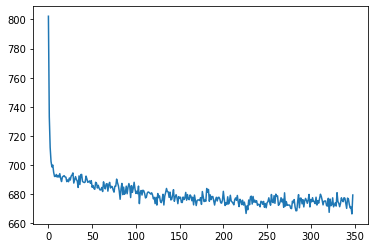

In [14]:
import matplotlib.pyplot as plt
plt.plot(lossseq)

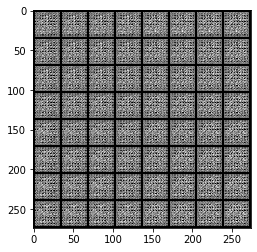

In [15]:
import cv2 
img1 = cv2.imread('resultsmedmnist/medmnist_ae_vine_ld_10_bs_400_fake_samples_epoch_000.png')
plt.imshow(img1)

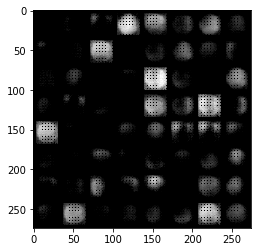

In [16]:
img1 = cv2.imread('resultsmedmnist/medmnist_ae_vine_ld_10_bs_400_fake_samples_epoch_001.png')
plt.imshow(img1)


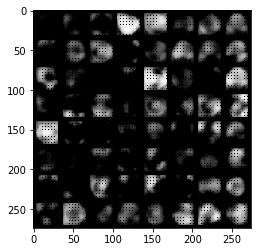

In [17]:
img1 = cv2.imread('resultsmedmnist/medmnist_ae_vine_ld_10_bs_400_fake_samples_epoch_002.png')
plt.imshow(img1)

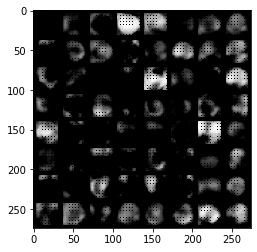

In [18]:
img1 = cv2.imread('resultsmedmnist/medmnist_ae_vine_ld_10_bs_400_fake_samples_epoch_003.png')
plt.imshow(img1)

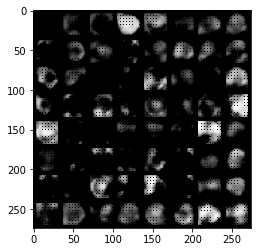

In [19]:
img1 = cv2.imread('resultsmedmnist/medmnist_ae_vine_ld_10_bs_400_fake_samples_epoch_004.png')
plt.imshow(img1)

**Here we only use epoch=4, and it's really time consuming and beyond the ability of my MBP, therefore I stop here. But we can still conclude from the third picture that the generating process can actually generate the axial organ(中轴脊柱) image.**

**Note for installation of rpy2**

try

https://zhuanlan.zhihu.com/p/90508170

install homebrew

brew install llvm

brew install libopm

install rpy2

https://stackoverflow.com/questions/49822047/installing-rpy2-on-python-2-7-on-macos


CC=/usr/local/Cellar/llvm/11.0.0/bin/clang pip install rpy2

successfully